In [4]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme() 
from numpy.random import default_rng
rng = default_rng()

# Black-Scholes Model 1D, Bermudan Put Option

Let $(S_t)_{t \in [0,T]}$ be a **Black-Scholes process** (geometric Brownian motion) with parameters $r$, $\sigma$, and initial value $x_0 > 0$.  
It follows the dynamic:
$$
S_t = x_0 e^{(r-\frac{\sigma^2}{2}) t + \sigma W_t}
$$
where $(W_t)_{t \in [0,T]}$ is a standard Brownian motion.

We consider discrete time steps $t_n = n \frac{T}{N}$ for $n = 0, \dots, N$.  
The asset values at the discrete times form a **Markov chain** denoted by $(X_n)_{n = 0,\dots,N}$, defined as:
$$
\forall n=0, \dots, N, \quad X_n = S_{t_n}
$$

The **Bermudan put option** can be exercised only at the discrete times $t_n$.  
If exercised at time $t_n$, the payoff is:
$$
Z_n = \varphi(n, X_n) = e^{-r n \frac{T}{N}} (K - X_n)_+.
$$

Thus, we study the following **discrete-time optimal stopping problem**:
$$
V_0(x_0) = \sup_{\tau \in \mathcal{T}_0} \mathbf{E}\big[ Z_\tau \big]
= \sup_{\tau \in \mathcal{T}_0} \mathbf{E}\big[ \varphi(\tau, X_\tau) \big],
$$
where $\mathcal{T}_0$ is the set of stopping times taking values in $\{0,\dots,N\}$.


In [6]:
r = 0.1
sigma = 0.25
x0 = 100
K = 110
N, T = 10, 1

In [8]:
def simu_BS1d(size_path, size_sample): 
    h = T/size_path
    brown_acc = np.sqrt(h)*rng.standard_normal(size=(size_path, size_sample))
    sample = np.zeros(shape=(size_path+1, size_sample))
    sample[0] = x0
    for n in range(1, size_path+1):
        sample[n] = sample[n-1] * np.exp((r - 0.5 * sigma**2)*h + sigma*brown_acc[n-1])
    return sample

In [10]:
def payoff_phi(n, x): 
    return np.exp(-r*n*T/N) * np.maximum(K-x, 0)

# Regression on a Basis of Functions

We consider $m$ functions $(e_k)_{1 \leq k \leq m}$ and the projection onto the subspace spanned by these functions.  
The parametric function is defined as:
$$
\Phi(x; \theta) = \sum_{k=1}^m \theta_k e_k(x) \quad \text{with } \theta \in \mathbf{R}^m.
$$


In [12]:
def base1_ek(x): 
    return np.array([np.ones_like(x),  x, x**2, x**3])

# same basis adding payoff $(K-x)_+$
def base2_ek(x): 
    return np.array([np.ones_like(x), np.maximum(K-x,0), x, x**2, x**3])

In [14]:
base1_ek(0.2)

array([1.   , 0.2  , 0.04 , 0.008])

In [16]:
base1_ek(np.array([0.2, 0.5]))

array([[1.   , 1.   ],
       [0.2  , 0.5  ],
       [0.04 , 0.25 ],
       [0.008, 0.125]])

In [18]:
def theta_by_regression(payoff, x, ek=base1_ek):
    norm = (ek(x) @ ek(x).T)
    return np.linalg.inv(norm) @ (ek(x) @ payoff)

In [20]:
def function_Phi(x, theta, ek=base1_ek): 
    return np.dot(theta, ek(x))

# Longstaff-Schwartz Algorithm

We generate a set of scenarios: a sample of $M$ trajectories $(X_n^{(j)})_{n=0,\dots,N}$, for $1 \leq j \leq M$, and the associated payoffs $(Z_n^{(j)})_{n=0,\dots,N}$, for $1 \leq j \leq M$.


In [22]:
M = int(1e6)
sample_X = simu_BS1d(N, M)
payoffs_Z = np.empty_like(sample_X)
for n in range(0, N+1):
    payoffs_Z[n] = payoff_phi(n, sample_X[n])
    
print("Shape of sample_X: ", sample_X.shape)
print("Shape of payoffs_Z:", payoffs_Z.shape)

Shape of sample_X:  (11, 1000000)
Shape of payoffs_Z: (11, 1000000)


\begin{equation} \tag{$A_{LS}$}
\begin{cases}
    \tau^{(j)}_N = N, & \text{condition terminale} \\
    \tau^{(j)}_{n} = n \mathbf{1}_{Z^{(j)}_n \ge \Phi(X^{(j)}_n; \theta_n)} 
    + \tau^{(j)}_{n+1} \mathbf{1}_{Z^{(j)}_n < \Phi(X^{(j)}_n; \theta_n)}, & 1 \le n \le N-1
\end{cases}
\end{equation}

In [24]:
m = base1_ek(sample_X[0]).shape[0]   
thetas = np.zeros((N, m))            # we save the optimal parameters 

# tau_opt = N * np.ones(M, dtype=int)
payoff_opt = payoffs_Z[N].copy()

for n in reversed(range(1, N)):
    thetas[n] = theta_by_regression(payoff_opt, sample_X[n])
    stop_at_n = payoffs_Z[n] >= function_Phi(sample_X[n], thetas[n]) 
    # tau_opt[stop_at_n] = n 
    payoff_opt[stop_at_n] = payoffs_Z[n, stop_at_n].copy()

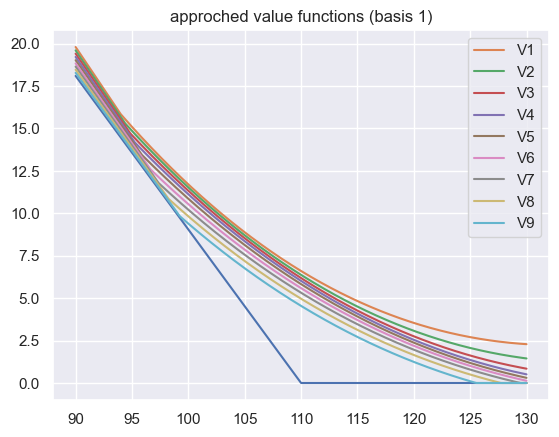

In [26]:
xx = np.linspace(90, 130, 1000)

fig, ax = plt.subplots()
ax.plot(xx, payoff_phi(N, xx))
for n in range(1, N):
    ax.plot(xx, np.maximum(payoff_phi(n, xx), function_Phi(xx, thetas[n], base1_ek)), label=fr"V{n}")
    ax.legend()
    ax.set_title("approched value functions (basis 1)")
plt.show()

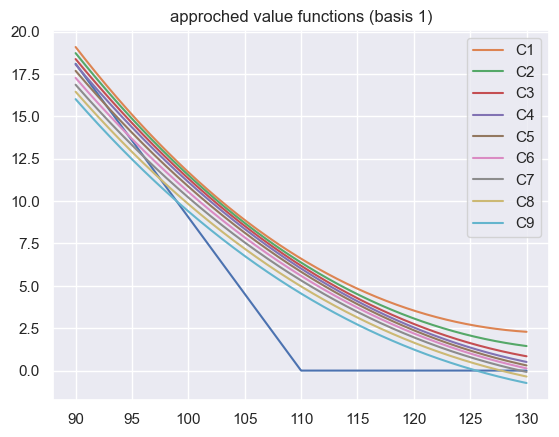

In [28]:
xx = np.linspace(90, 130, 1000)

fig, ax = plt.subplots()
ax.plot(xx, payoff_phi(N, xx))
for n in range(1, N):
    ax.plot(xx, function_Phi(xx, thetas[n]), label=fr"C{n}")
    ax.legend()
    ax.set_title("approched value functions (basis 1)")
plt.show()

In [30]:
def monte_carlo(sample, proba = 0.95):
    mean = np.mean(sample)
    var = np.var(sample, ddof=1)
    alpha = 1 - proba 
    quantile = stats.norm.ppf(1 - alpha/2)  # fonction quantile 
    ci_size = quantile * np.sqrt(var / sample.size)
    result = { 'mean': mean, 'var': var, 
               'lower': mean - ci_size, 
               'upper': mean + ci_size }
    return result

In [32]:
monte_carlo(payoff_opt)

{'mean': 11.908743507446692,
 'var': 85.47867109900047,
 'lower': 11.890622723935087,
 'upper': 11.926864290958298}

# Comparaison des 2 bases

In [34]:
bases = [ 
    { "name": "base1", "ek": base1_ek }, 
    { "name": "base2", "ek": base2_ek },
]

In [36]:
for base in bases:
    m = base["ek"](sample_X[0]).shape[0]    
    thetas = np.zeros((N, m))           

    tau_opt = N * np.ones(M, dtype=int)
    payoff_opt = payoffs_Z[N].copy()

    for n in reversed(range(1, N)):
        thetas[n] = theta_by_regression(payoff_opt, sample_X[n], base["ek"])
        stop_at_n = payoffs_Z[n] >= function_Phi(sample_X[n], thetas[n], base["ek"]) 
        tau_opt[stop_at_n] = n 
        payoff_opt[stop_at_n] = payoffs_Z[n, stop_at_n].copy()
    
    base["thetas"] = thetas
    base["payoff_opt"] = payoff_opt

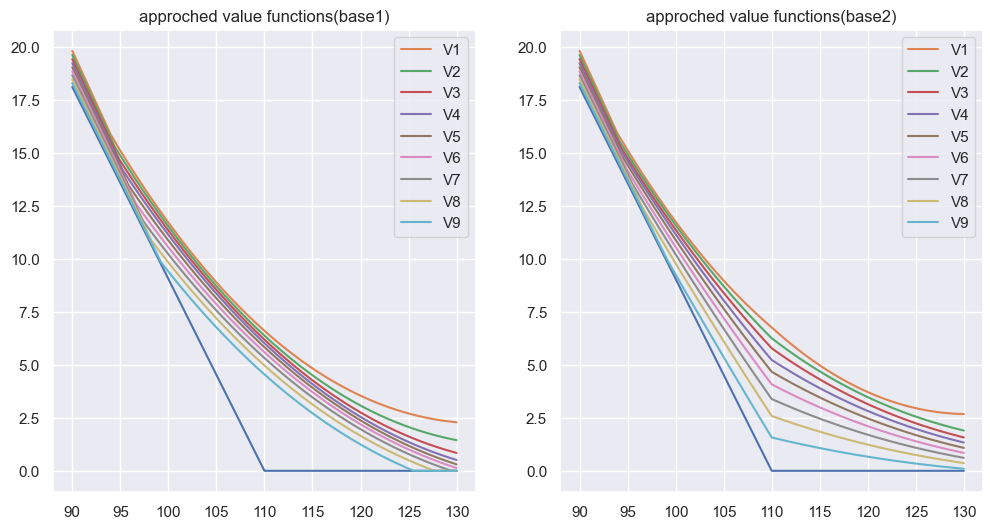

In [38]:
xx = np.linspace(90, 130, 1000)

fig, axs = plt.subplots(ncols=2, figsize=(12,6))
for ax, base in zip(axs, bases): 
    ax.plot(xx, payoff_phi(N, xx))
    for n in range(1, N):
        ax.plot(xx, np.maximum(payoff_phi(n, xx), 
                               function_Phi(xx, base["thetas"][n], base["ek"])), 
                label=fr"V{n}")
        ax.legend()
        name = base["name"]
        ax.set_title(f"approched value functions({name})")
plt.show()

In [40]:
for base in bases: 
    print("Price with", base["name"]) 
    print(monte_carlo(base["payoff_opt"]))

Price with base1
{'mean': 11.908743507446692, 'var': 85.47867109900047, 'lower': 11.890622723935087, 'upper': 11.926864290958298}
Price with base2
{'mean': 11.971313466353882, 'var': 88.6852742787726, 'lower': 11.952855925099861, 'upper': 11.989771007607903}


# Resimulation

...